In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import itertools

In [ ]:
def f(x, thrust, target_pitch_rad, g):
    return ((g/thrust) + np.tan(target_pitch_rad)*np.cos(x) - np.sin(x))

def fprime(x, thrust, target_pitch_rad, g):
    return (-np.tan(target_pitch_rad)*np.sin(x) - np.cos(x))

In [75]:
# Set the gravity to 1 so that we can easily scale the effective thrust in rust.
# effective_thrust = thrust/g
g = 1
thrusts = np.linspace(1, 5, 30)
target_pitches_deg = np.linspace(-90, 90, 181)
target_pitches_rad = np.deg2rad(target_pitches_deg)
thrusts_grid, target_pitches_rad_grid = np.meshgrid(thrusts, target_pitches_rad)
target_pitches_deg_grid = np.rad2deg(target_pitches_rad_grid)

heading_pitches_rad = optimize.newton(f, target_pitches_rad_grid, fprime=fprime, args=(thrusts_grid, target_pitches_rad_grid, g))
heading_pitches_deg = np.rad2deg(heading_pitches_rad)

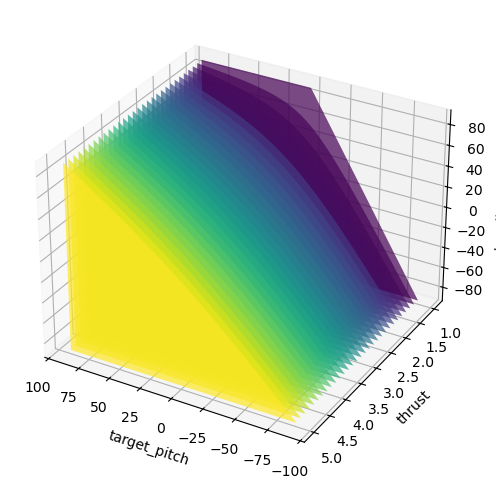

In [70]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1, projection="3d")

facecolors = plt.colormaps['viridis_r'](np.linspace(1, 0, len(thrusts)))

for i, thrust in enumerate(thrusts):
    ax1.fill_between(target_pitches_deg, thrust, heading_pitches_deg.T[i],
                     target_pitches_deg, thrust, -90,
                     facecolors=facecolors[i], alpha=.7)
    # ax1.fill_between(thrusts, target_pitch, heading_pitches_deg[i],
    #                  thrusts, target_pitch, -90,
    #                  facecolors=facecolors[i], alpha=.7)

ax1.set(
    xlabel=r"target_pitch",
    ylabel=r"thrust",
    zlabel=r"heading_pitch",
)
ax1.invert_xaxis()
ax1.invert_yaxis()

In [93]:
def list_to_rust_str(l):
    list_with_commas = ", ".join([str(float(x)) for x in l])
    return f": [f64; {len(l)}] = [{list_with_commas}]"

print(f"pub static GRAVITY: f64 = {float(g)};")
print(f"pub static THRUSTS{list_to_rust_str(thrusts)};")
print(f"pub static TARGET_PITCHES{list_to_rust_str(target_pitches_deg)};")
print(f"pub static HEADING_PITCHES_LOOKUP{list_to_rust_str(heading_pitches_deg.flatten())};")

pub static GRAVITY: f64 = 0.2;
pub static THRUSTS: [f64; 30] = [1.0, 1.1379310344827587, 1.2758620689655173, 1.4137931034482758, 1.5517241379310345, 1.6896551724137931, 1.8275862068965516, 1.9655172413793103, 2.103448275862069, 2.2413793103448274, 2.3793103448275863, 2.5172413793103448, 2.655172413793103, 2.793103448275862, 2.9310344827586206, 3.0689655172413794, 3.206896551724138, 3.3448275862068964, 3.4827586206896552, 3.6206896551724137, 3.7586206896551726, 3.896551724137931, 4.0344827586206895, 4.172413793103448, 4.310344827586206, 4.448275862068965, 4.586206896551724, 4.724137931034482, 4.862068965517241, 5.0];
pub static TARGET_PITCHES: [f64; 181] = [-90.0, -89.0, -88.0, -87.0, -86.0, -85.0, -84.0, -83.0, -82.0, -81.0, -80.0, -79.0, -78.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0, -70.0, -69.0, -68.0, -67.0, -66.0, -65.0, -64.0, -63.0, -62.0, -61.0, -60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54.0, -53.0, -52.0, -51.0, -50.0, -49.0, -48.0, -47.0, -46.0, -45.0, -44.0, -43.0,

In [100]:
def print_test_case(g, thrust, target_pitch_deg):
    target_pitch_rad = np.deg2rad(target_pitch_deg)
    out_rad = optimize.newton(f, target_pitch_rad, fprime=fprime, args=(thrust, target_pitch_rad, g))
    out_deg = np.rad2deg(out_rad)
    print(f"assert_relative_eq!(lookup_gravity_heading({g}, {target_pitch_deg}, {thrust}), {out_deg}, epsilon=0.8);")

for g, thrust, target_pitch_deg in itertools.product(np.linspace(0.2, 0.2, 1), np.linspace(0.2, 5, 10), np.linspace(-90, 90, 181)):
    print_test_case(g, thrust, target_pitch_deg)

assert_relative_eq!(lookup_gravity_heading(0.2, -90.0, 0.2), -90.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -89.0, 0.2), -88.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -88.0, 0.2), -86.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -87.0, 0.2), -83.99999999999999, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -86.0, 0.2), -82.00000000000001, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -85.0, 0.2), -80.00000000000001, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -84.0, 0.2), -78.00000000000001, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -83.0, 0.2), -76.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -82.0, 0.2), -74.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -81.0, 0.2), -72.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2, -80.0, 0.2), -70.0, epsilon=0.8);
assert_relative_eq!(lookup_gravity_heading(0.2

In [99]:
print_test_case(0.2, 0.2, -87)

assert_relative_eq!(lookup_gravity_heading(0.2, -87, 0.2), -83.99999999999999, epsilon=0.8);
